# Bounding the subspace dimension

In this tutorial, we will show the effect of the subspace dimension in the [self-consistent configuration recovery technique](https://arxiv.org/abs/2405.05068).

***A priori***, we do not know what is the correct subspace dimension to obtain a target level of accuracy. However, we do know that increasing the subspace dimension increases the accuracy of the method. Therefore, we can study the accuracy of the predictions as a function of the subspace dimension.

Specify the molecule and its properties.

In [1]:
import warnings

import pyscf
import pyscf.cc
import pyscf.mcscf

warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570775
CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


Generate some random bitstrings to proxy QPU samples.

In [2]:
import numpy as np
from qiskit_addon_sqd.counts import generate_bit_array_uniform

# Create a seed to control randomness throughout this workflow
rng = np.random.default_rng(24)

# Generate random samples
bit_array = generate_bit_array_uniform(10_000, num_orbitals * 2, rand_seed=rng)

Call SQD with increasing batch sizes.

In [3]:
from qiskit_addon_sqd.fermion import diagonalize_fermionic_hamiltonian

list_samples_per_batch = [50, 200, 400, 600]

# SQD options
max_iterations = 5

# Eigenstate solver options
num_batches = 10
max_davidson_cycles = 200

energies = []
subspace_dimensions = []

for samples_per_batch in list_samples_per_batch:
    result = diagonalize_fermionic_hamiltonian(
        hcore,
        eri,
        bit_array,
        samples_per_batch=samples_per_batch,
        norb=num_orbitals,
        nelec=(num_elec_a, num_elec_b),
        num_batches=num_batches,
        max_iterations=max_iterations,
        symmetrize_spin=True,
        seed=rng,
    )
    energies.append(result.energy)
    subspace_dimensions.append(np.prod(result.sci_state.amplitudes.shape))

This plot shows that increasing the subspace dimension leads to more accurate results.

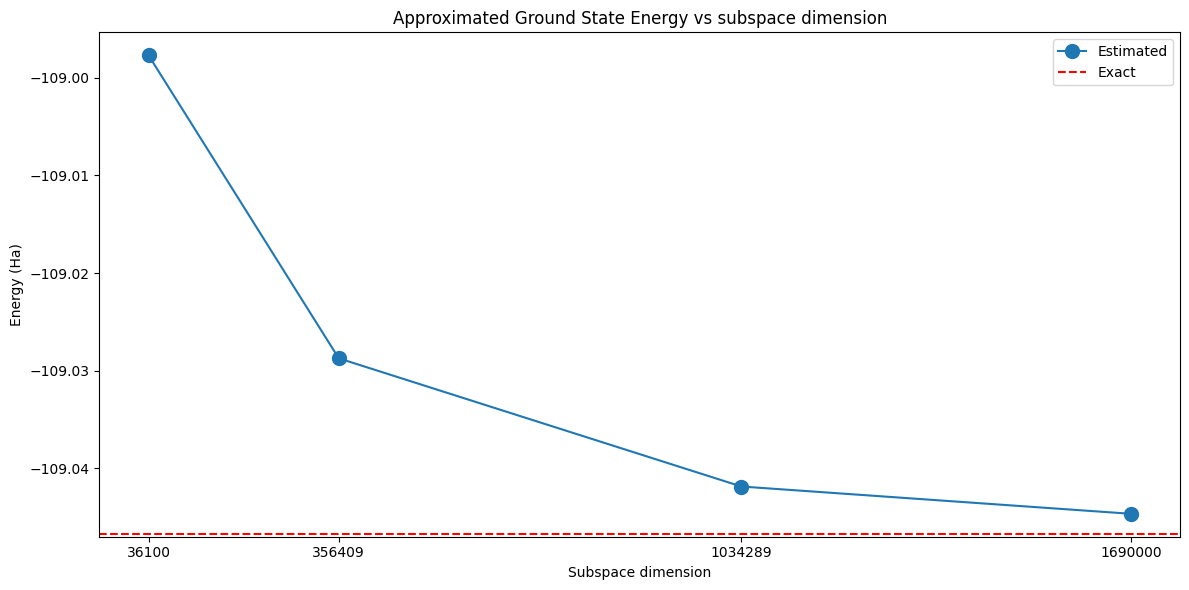

In [4]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = subspace_dimensions
y1 = np.array(energies) + nuclear_repulsion_energy

fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# Plot energies
axs.plot(x1, y1, marker=".", markersize=20, label="Estimated")
axs.set_xticks(x1)
axs.set_xticklabels(x1)
axs.axhline(y=exact_energy, color="red", linestyle="--", label="Exact")
axs.set_title("Approximated Ground State Energy vs subspace dimension")
axs.set_xlabel("Subspace dimension")
axs.set_ylabel("Energy (Ha)")
axs.legend()


plt.tight_layout()
plt.show()